In [1]:
import pandas as pd
import plotly.io as pio
import plotly.graph_objects as go
from plotly.subplots import make_subplots

In [23]:
df_austin = pd.read_csv('data/df_austin.csv')
df_charlotte = pd.read_csv("data/df_charlotte.csv")
df_greensboro = pd.read_csv("data/df_greensboro.csv")
df_MD = pd.read_csv('data/df_MD.csv')
df_nashville = pd.read_csv("data/df_nashville.csv")
df_neworleans = pd.read_csv("data/df_neworleans.csv")
df_raleigh = pd.read_csv("data/df_raleigh.csv")
df_sandiego = pd.read_csv("data/df_sandiego.csv")
df_sanfrancisco = pd.read_csv("data/df_sanfrancisco.csv")
df_WA = pd.read_csv("data/df_WA.csv")



dicto = {'austin': df_austin,'charlotte': df_charlotte, 'greensboro': df_greensboro,'MD': df_MD,'nashville': df_nashville, 'neworleans': df_neworleans,
         'raleigh': df_raleigh, 'sandiego': df_sandiego,'sanfrancisco': df_sanfrancisco,'WA': df_WA}

df = pd.DataFrame(columns = ["name",'total_m', 'total_f', 'stop_rate_m',"stop_rate_f","search_rate_arrest_m","search_rate_arrest_f",
                             "search_rate_contraband_m","search_rate_contraband_f","frisk_rate_m","frisk_rate_f"]) 

/usr/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3146: DtypeWarning:

Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.



In [24]:
#we have lost some columns
for name in ["austin","charlotte","greensboro","MD","nashville","neworleans","raleigh","sandiego","sanfrancisco","WA"]:
    data = dicto[name]
    print(data.shape[1])
    

10
14
14
12
12
12
14
12
10
10


In [36]:
df_WA

,Unnamed: 0,subject_age,subject_race,subject_sex,officer_sex,arrest_made,citation_issued,warning_issued,contraband_found,frisk_performed
0,7,18.0,white,male,male,NaN,True,True,False,False
1,61,47.0,white,male,male,NaN,True,True,False,False
2,62,23.0,white,male,male,NaN,True,True,False,False
3,82,44.0,white,male,male,NaN,True,True,True,False
4,87,35.0,other,female,male,NaN,True,True,False,False
...,...,...,...,...,...,...,...,...,...,...
239592,11333144,29.0,asian/pacific islander,male,male,NaN,True,True,False,False
239593,11333165,27.0,white,male,male,NaN,True,True,False,False
239594,11333199,38.0,hispanic,male,male,NaN,True,False,False,False
239595,11333258,64.0,white,male,male,NaN,True,True,False,False


In [37]:
list_name = ["austin","charlotte","greensboro","MD","nashville","neworleans","raleigh","sandiego","sanfrancisco","WA"]
list_name = ["austin","charlotte","greensboro","MD","nashville","neworleans","raleigh","sandiego"]

population_dico = {'austin': [978908,0.492],'charlotte': [885708,0.481], 'greensboro': [296710,0.535],'MD': [6045680,0.516],'nashville': [694144,0.518], 'neworleans': [390144,0.525],
         'raleigh': [474069,0.518], 'sandiego': [1423851,0.495],'sanfrancisco': [881549,0.490],'WA': [7614893,0.499]}

for name in list_name:

    data = dicto[name]
    print(name)
    #distribution dataset
    total_m = data[data["subject_sex"] == "male"]
    total_f = data[data["subject_sex"] == "female"]
    #print(total_m.shape[0])
    #print(total_f.shape[0])

    # stop rate 
    # https://www.census.gov/quickfacts/charlottecitynorthcarolina
    population_charlotte = population_dico[name][0]
    population_charlotte_m = int(population_charlotte*population_dico[name][1])
    population_charlotte_f = population_charlotte - population_charlotte_m

    stop_rate_m = total_m.shape[0] / population_charlotte_m 
    stop_rate_f = total_f.shape[0] / population_charlotte_f
    #print(stop_rate_f)
    #print(stop_rate_m)

    # Search rates
    search_rate_arrest_m = []
    search_rate_arrest_f = []
    search_rate_contraband_m = []
    search_rate_contraband_f = []

    for name_search in ["search_person","search_vehicle"]:
        if name_search != "search_person" or name != "WA":
            total_search_m = total_m[total_m[name_search] == True]
            total_search_f = total_f[total_f[name_search] == True]

            if name != "austin":

                search_arrest_m = total_search_m[total_search_m["arrest_made"] == True]
                search_arrest_f = total_search_f[total_search_f["arrest_made"] == True]

                search_rate_arrest_m.append(search_arrest_m.shape[0]/total_search_m.shape[0])
                search_rate_arrest_f.append(search_arrest_f.shape[0]/total_search_f.shape[0])

            #print(" -- "+name_search+" arrest made")
            #print(search_rate_arrest_f)
            #print(search_rate_arrest_m)

            search_contraband_m = total_search_m[total_search_m["contraband_found"] == True]
            search_contraband_f = total_search_f[total_search_f["contraband_found"] == True]

            search_rate_contraband_m.append(search_contraband_m.shape[0]/total_search_m.shape[0])
            search_rate_contraband_f.append(search_contraband_f.shape[0]/total_search_f.shape[0])

            #print(" -- "+name_search+" contraband found")
            #print(search_rate_contraband_f)
            #print(search_rate_contraband_m)

    # frisk rate
    # Search rates
    """
    total_frisk_m = total_m[total_m["frisk_performed"] == True]
    total_frisk_f = total_f[total_f["frisk_performed"] == True]

    frisk_m = total_frisk_m[total_frisk_m["arrest_made"] == True]
    frisk_f = total_frisk_f[total_frisk_f["arrest_made"] == True]

    frisk_rate_m = frisk_m.shape[0]/total_frisk_m.shape[0]
    frisk_rate_f = frisk_f.shape[0]/total_frisk_f.shape[0]

    #print(frisk_rate_f)
    #print(frisk_rate_m)
    """

    ['total_m', 'total_f', 'stop_rate_m',"stop_rate_f","search_rate_arrest_m","search_rate_arrest_f",
                                 "search_rate_contraband_m","search_rate_contraband_f","frisk_rate_m","frisk_rate_f"]

    df = df.append({"name" : name,'total_m' : total_m.shape[0], 'total_f' : total_f.shape[0], 'stop_rate_m' : stop_rate_m,"stop_rate_f" : stop_rate_f,"search_rate_arrest_m" : search_rate_arrest_m ,
                    "search_rate_arrest_f" : search_rate_arrest_f,"search_rate_contraband_m" : search_rate_contraband_m,"search_rate_contraband_f" : search_rate_contraband_f},ignore_index = True)
                    #"frisk_rate_m" : frisk_rate_m,"frisk_rate_f" : frisk_rate_f},  
                    #ignore_index = True) 

print(df)

austin
charlotte
greensboro
MD
nashville
neworleans
raleigh
sandiego
          name total_m total_f  stop_rate_m  stop_rate_f  \
0       austin   13530    1509     0.028093     0.003034   
1    charlotte   80116   12762     0.188055     0.027763   
2   greensboro   26884    5051     0.169360     0.036609   
3           MD   22637    5726     0.007256     0.001957   
4    nashville   97119   29292     0.270101     0.087549   
5   neworleans   61978   13148     0.302590     0.070948   
6      raleigh   27555    5735     0.112210     0.025098   
7     sandiego   10934    2512     0.015513     0.003494   
8       austin   13530    1509     0.028093     0.003034   
9    charlotte   80116   12762     0.188055     0.027763   
10  greensboro   26884    5051     0.169360     0.036609   
11          MD   22637    5726     0.007256     0.001957   
12   nashville   97119   29292     0.270101     0.087549   
13  neworleans   61978   13148     0.302590     0.070948   
14     raleigh   27555    5735 

In [27]:
#hit rate

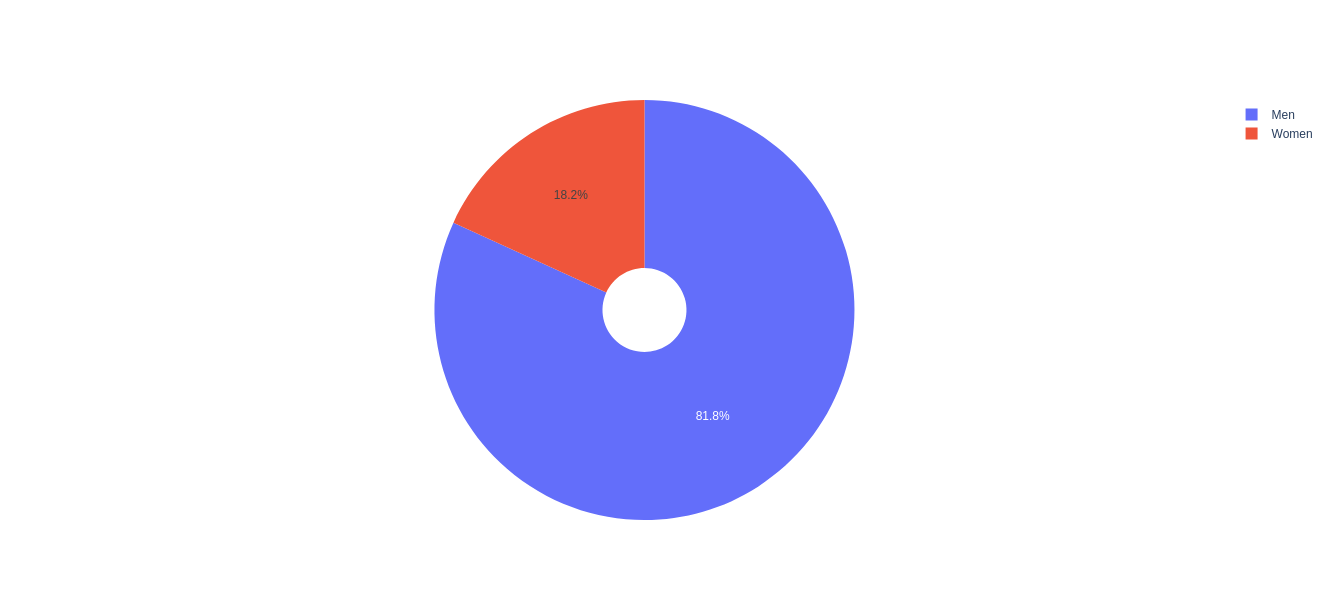

In [28]:
#first plot ,show % men women in our data
labels = ['Women','Men']
values = [df["total_f"].sum(), df["total_m"].sum()]
fig = go.Figure(data=[go.Pie(labels=labels, values=values, hole=.2)])
fig.update_layout(
        autosize=False,
        paper_bgcolor='rgba(0,0,0,0)',
        width=600,
        height=600,
        dragmode = False,
    )
fig.show()
#pio.write_html(fig, file='MenWomenTotal.html', auto_open=True)

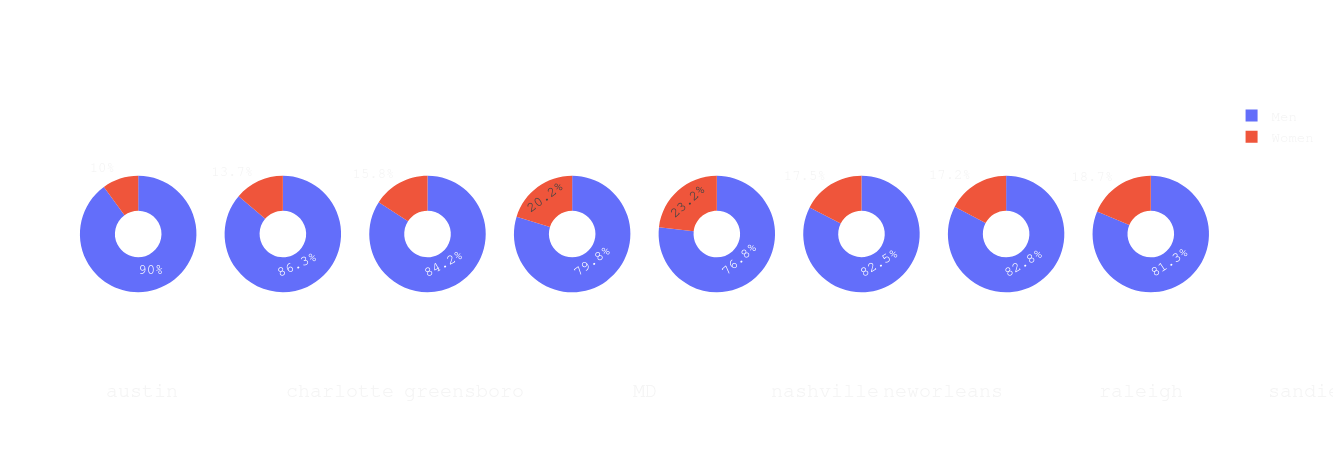

In [29]:
list_spec = []
for i in range(len(list_name)):
    list_spec.append({'type':'domain'})

fig = make_subplots(rows=1, cols=len(list_name), specs=[list_spec])
for i in range(len(list_name)):
    fig.add_trace(go.Pie(labels=labels, values=[df["total_f"][i],df["total_m"][i]], name=list_name[i]),1, 1+i)

# Use `hole` to create a donut-like pie chart
fig.update_traces(hole=.4, hoverinfo="label+percent+name")

annotation_circle = []
for i in range(len(list_name)):
    annotation_circle.append(dict(text=list_name[i], x=0.02+i*0.16, y=-0.15, font_size=20, showarrow=False))
    
fig.update_layout(
    # Add annotations in the center of the donut pies.
    font = dict(size=14, family='Courier', color="#F5F5F5"),
    paper_bgcolor='rgba(0,0,0,0)',
    annotations=annotation_circle)
fig.show()
#pio.write_html(fig, file='MenWomenList.html', auto_open=True)

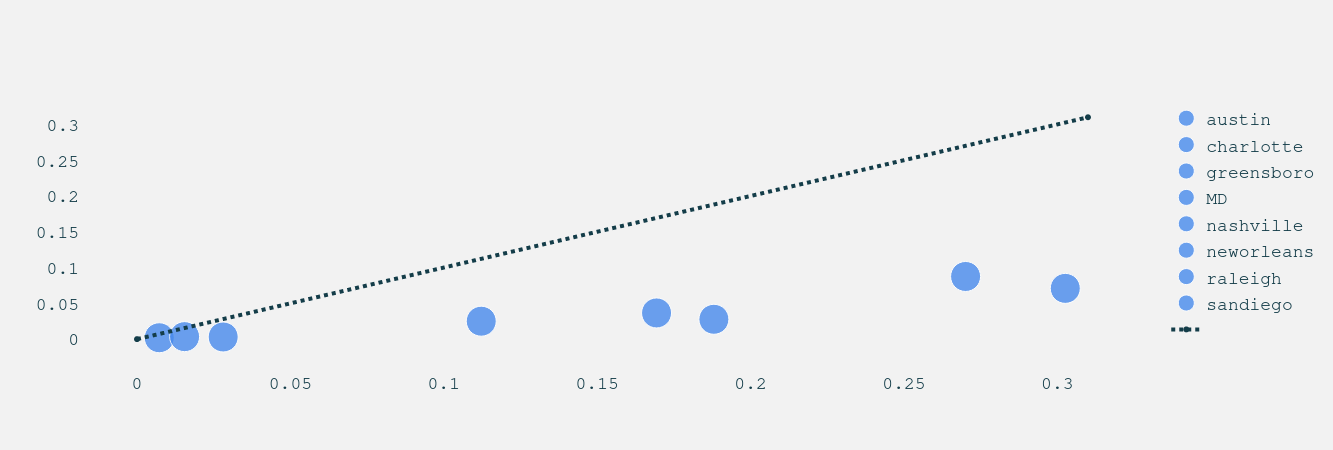

In [30]:
#stop rate
fig = go.Figure()


marker_var =dict(
        color=['#478AEC'],
        opacity=[0.8],
    )

for i in range(len(list_name)):
    fig.add_trace(go.Scatter(x=[df["stop_rate_m"][i]], y=[df["stop_rate_f"][i]],mode='markers', marker=marker_var ,name=list_name[i], marker_size=[30]))

    
color = "#478AEC"

fig.add_trace(go.Scatter(x=[0,0.31], y=[0,0.31], name='',line=dict(color='#143D49', width=4,dash='dot')))
fig.update_layout(
        font = dict(size=18, family='Courier', color="#143D49"),
        paper_bgcolor='#F2F2F2',
        plot_bgcolor='rgba(0,0,0,0)',
        autosize=True,
        dragmode = False,
    )


fig.update_xaxes(gridcolor = 'rgba(25, 229, 229,0)',title_font = dict(size=13, family='Courier', color=color),zeroline=False)
fig.update_yaxes(gridcolor = 'rgba(255, 229, 229,0)',title_font = dict(size=13, family='Courier', color=color),zeroline=False)
fig.show()
#pio.write_html(fig, file='stopRate.html', auto_open=True)

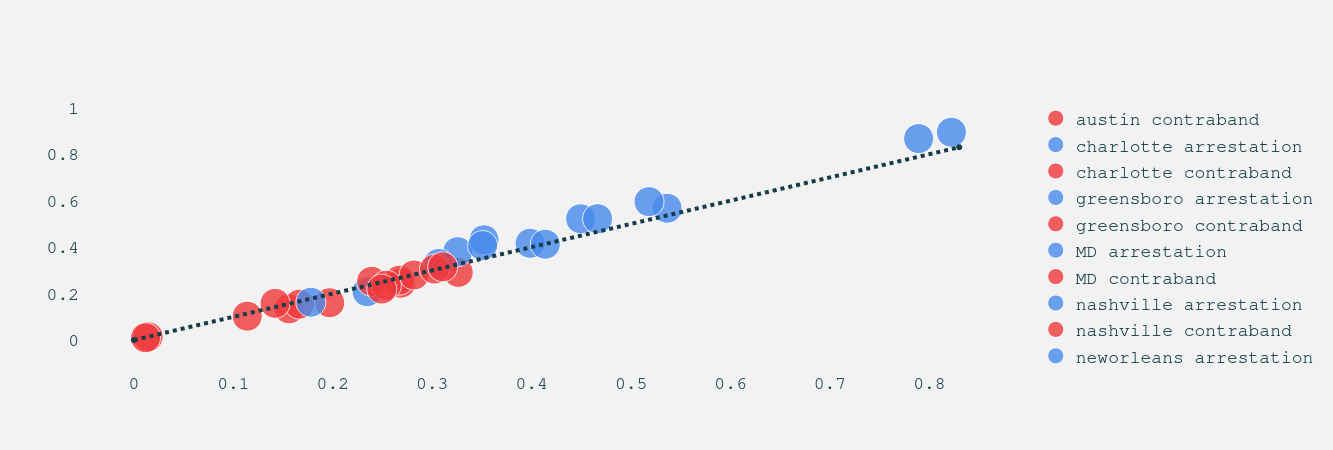

In [31]:
#searh rate
fig = go.Figure()


marker_var =dict(
        color=['#478AEC',"#478AEC"],
        opacity=[0.8,0.8],
    )
marker_var2 =dict(
        color=['#EF383B','#EF383B'],
        opacity=[0.8,0.8],
    )
marker_var3 =dict(
        color=['#002E79'],
        opacity=[0.8],
    )
marker_var4 =dict(
        color=['#E76A40'],
        opacity=[0.8],
    )
#"search_rate_arrest_m","search_rate_arrest_f", "search_rate_contreband_m","search_rate_contreband_f"
for i in range(len(list_name)):
    fig.add_trace(go.Scatter(x=df["search_rate_arrest_m"][i], y=df["search_rate_arrest_f"][i],mode='markers', marker=marker_var ,name=list_name[i]+" arrestation", marker_size=[30,30],text=['<br>search_person', '<br>search_vehicle']))
    fig.add_trace(go.Scatter(x=df["search_rate_contraband_m"][i], y=df["search_rate_contraband_f"][i],mode='markers', marker=marker_var2 ,name=list_name[i]+" contraband", marker_size=[30,30],text=['<br>search_person', '<br>search_vehicle']))
    
color = "#478AEC"

fig.add_trace(go.Scatter(x=[0,0.83], y=[0,0.83], name='',line=dict(color='#143D49', width=4,dash='dot')))
fig.update_layout(
        font = dict(size=18, family='Courier', color="#143D49"),
        paper_bgcolor='#F2F2F2',
        plot_bgcolor='rgba(0,0,0,0)',
        autosize=True,

        dragmode = False,
    )


fig.update_xaxes(gridcolor = 'rgba(25, 229, 229,0)',title_font = dict(size=13, family='Courier', color=color),zeroline=False)
fig.update_yaxes(gridcolor = 'rgba(255, 229, 229,0)',title_font = dict(size=13, family='Courier', color=color),zeroline=False)
fig.show()
#pio.write_html(fig, file='searchRate.html', auto_open=True)

['TX', 'NC', 'NC', 'MD', 'TN', 'LA', 'NC', 'CA']


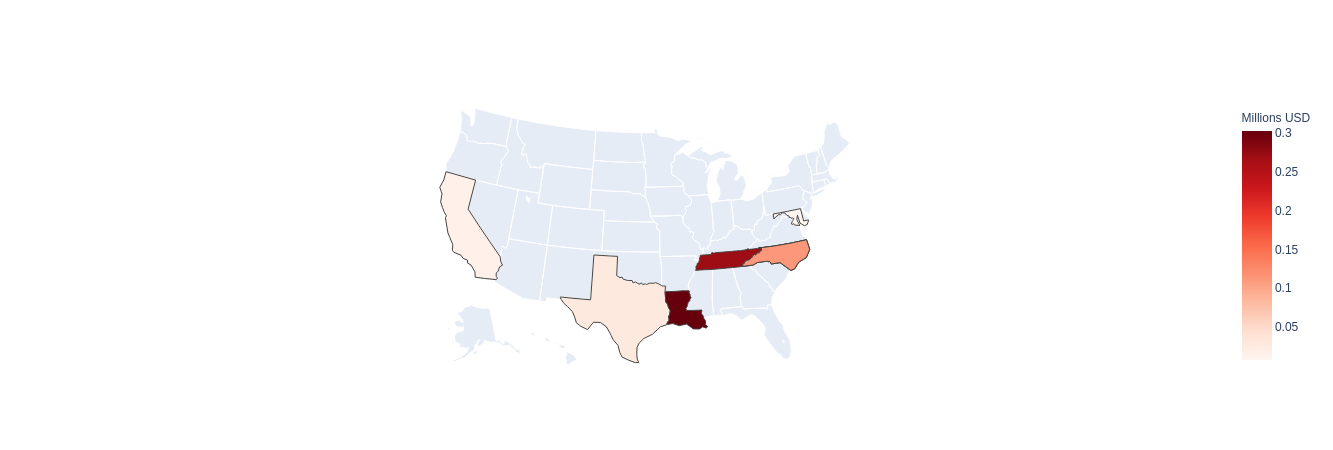

In [32]:
#df = pd.read_csv('https://raw.githubusercontent.com/plotly/datasets/master/2011_us_ag_exports.csv')

code_state = {'austin': "TX",'charlotte': "NC", 'greensboro': "NC",'MD': "MD",'nashville': "TN", 'neworleans': "LA",
         'raleigh': "NC", 'sandiego': "CA",'sanfrancisco': "CA",'WA': "WA"}

list_state = [code_state[v] for v in list_name]
print(list_state)

fig = go.Figure(data=go.Choropleth(
    locations=list_state, # Spatial coordinates
    z = df['stop_rate_m'].astype(float), # Data to be color-coded
    locationmode = 'USA-states', # set of locations match entries in `locations`
    colorscale = 'Reds',
    colorbar_title = "Millions USD",
))

fig.update_layout(
    geo_scope='usa', # limite map scope to USA
)

fig.show()
#print(df['code'])